/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'neurons': 877, 'epochs': 336, 'batch_size': 28}
train 정확도: 1.0000
test 정확도: 0.7059
total 정확도: 0.9412
others 정확도: 0.9434
[[40  0  0  0]
 [ 0  2  0  0]
 [ 0  0 12  0]
 [ 0  0  0 14]]
[[6 0 2 1]
 [1 0 0 0]
 [0 0 2 1]
 [0 0 0 4]]
[[46  0  2  1]
 [ 1  2  0  0]
 [ 0  0 14  1]
 [ 0  0  0 18]]
[[50  0  0  3]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


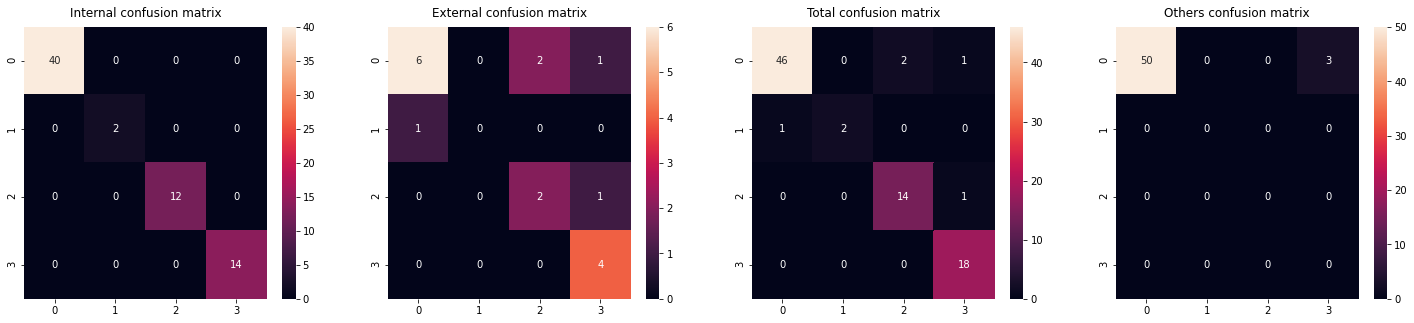

In [4]:
#ANN


# Use scikit-learn to grid search the batch size and epochs
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, KFold,  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, MaxAbsScaler,  QuantileTransformer
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.decomposition import PCA
from sklearn.utils.fixes import loguniform
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.utils import np_utils
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN

# fix random seed for reproducibility

seed = 0
np.random.seed(seed)

# load dataset

df = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/MORDRED(3D)/VRK2_MORDRED(3D)_apppendscore_dropsmiles.csv')
df1 = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/MORDRED(3D)/VRK2add_MORDRED(3D)_apppendscore_dropsmiles.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/Others/MORDRED(3D)/Others_MORDRED(3D)_appendscore_dropsmiles.csv')
df3 = pd.concat([df,df1,df2])
data = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/Others/MORDRED(3D)/Drug_MORDRED(3D)_appendscore_dropsmiles.csv')

#데이터 분류
#dataset = df.values
#X = dataset[:,:-1]
#Y = dataset[:,-1]

#dataset2 = df2.values
#X_ex = dataset2[:,:-1]
#Y_ex = dataset2[:,-1]

dataset3 = df3.values
X = dataset3[:,:-1]
Y = dataset3[:,-1]

data = data.values
X_others =data[:,:-1]
Y_others =data[:,-1]

Scaler = StandardScaler()

X_scaled = Scaler.fit_transform(X)
X_others_scaled = Scaler.transform(X_others)

# Function to create model, required for KerasClassifier

n_feat = X.shape[1]
n_class = len(set(Y))

def create_model(neurons=100):
	# create model
	model = Sequential()
	model.add(Dense(neurons, input_dim=n_feat, activation='relu'))
	model.add(Dense(n_class, activation='sigmoid'))
	# Compile model
	model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# create model

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters

#데이터 split

train_input, test_input, train_target, test_target = train_test_split(X_scaled, Y, test_size=0.2, random_state=seed)

#그리드 생성

param_grid = [{'batch_size': list(range(1,100)), 'epochs': list(range(1,500)), 'neurons': list(range(10,5000))}]
grid = RandomizedSearchCV(model, param_grid, n_jobs=-1, n_iter= 500, cv=5, scoring='accuracy')  
grid.fit(train_input,train_target)

pred_train = grid.predict(train_input)
pred_test = grid.predict(test_input)
pred_total = grid.predict(X_scaled)
pred_others = grid.predict(X_others_scaled)
accuracy = accuracy_score(train_target, pred_train)
ex_accuracy = accuracy_score(test_target, pred_test)
tot_accuracy = accuracy_score(Y, pred_total)
others_accuracy = accuracy_score(Y_others, pred_others)

print(grid.best_params_)

print('train 정확도: {0:.4f}'.format(accuracy))
print('test 정확도: {0:.4f}'.format(ex_accuracy))
print('total 정확도: {0:.4f}'.format(tot_accuracy))
print('others 정확도: {0:.4f}'.format(others_accuracy))

conf = confusion_matrix(train_target, pred_train, labels=[0,1,2,3])
exconf = confusion_matrix(test_target, pred_test, labels=[0,1,2,3])
totconf = confusion_matrix(Y, pred_total, labels=[0,1,2,3])
othersconf = confusion_matrix(Y_others, pred_others, labels=[0,1,2,3])

print(conf)
print(exconf)
print(totconf)
print(othersconf) 

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(25, 5))
sns.heatmap(conf, annot=True, ax=ax[0])
ax[0].set_title('Internal confusion matrix', pad = 10)
sns.heatmap(exconf, annot=True, ax=ax[1])
ax[1].set_title('External confusion matrix', pad = 10)
sns.heatmap(totconf, annot=True, ax=ax[2])
ax[2].set_title('Total confusion matrix', pad = 10)
sns.heatmap(othersconf, annot=True, ax=ax[3])
ax[3].set_title('Others confusion matrix', pad = 10)

plt.show()

#Classification report

#print(classification_report(test_target, pred_test))

#모델 저장

#model = grid.best_estimator_
#model.save('/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/VRK2_0416_ann1.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/336
3/3 [==============================] - 0s 15ms/step - loss: 2.3353 - accuracy: 0.2689
Epoch 2/336
3/3 [==============================] - 0s 12ms/step - loss: 0.7513 - accuracy: 0.7692
Epoch 3/336
3/3 [==============================] - 0s 14ms/step - loss: 0.3738 - accuracy: 0.9010
Epoch 4/336
3/3 [==============================] - 0s 14ms/step - loss: 0.0912 - accuracy: 0.9882
Epoch 5/336
3/3 [==============================] - 0s 12ms/step - loss: 0.3274 - accuracy: 0.9097
Epoch 6/336
3/3 [==============================] - 0s 14ms/step - loss: 0.0683 - accuracy: 0.9601
Epoch 7/336
3/3 [==============================] - 0s 14ms/step - loss: 0.1440 - accuracy: 0.9320
Epoch 8/336
3/3 [==============================] - 0s 13ms/step - loss: 0.1180 - accuracy: 0.9585
Epoch 9/336
3/3 [==============================] - 0s 12ms/step - loss: 0.0183 - accura

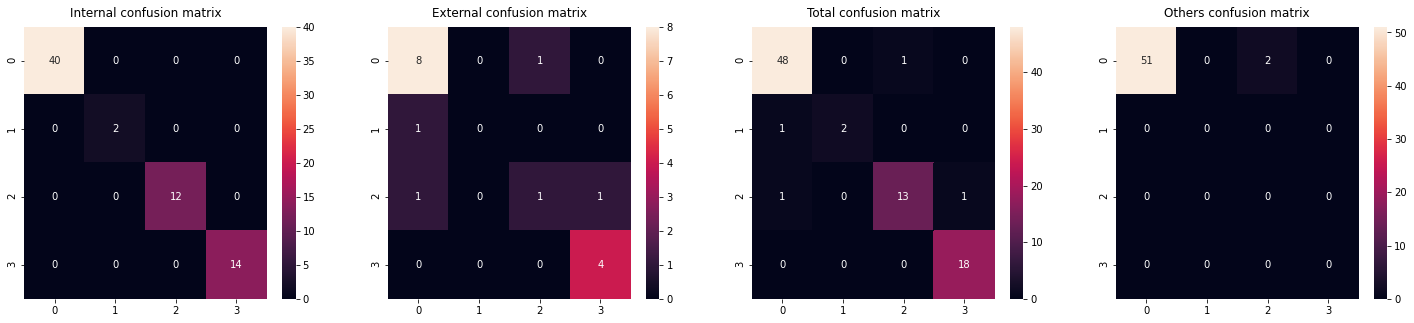

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.00      0.00      0.00         1
           2       0.50      0.33      0.40         3
           3       0.80      1.00      0.89         4

    accuracy                           0.76        17
   macro avg       0.53      0.56      0.53        17
weighted avg       0.70      0.76      0.73        17



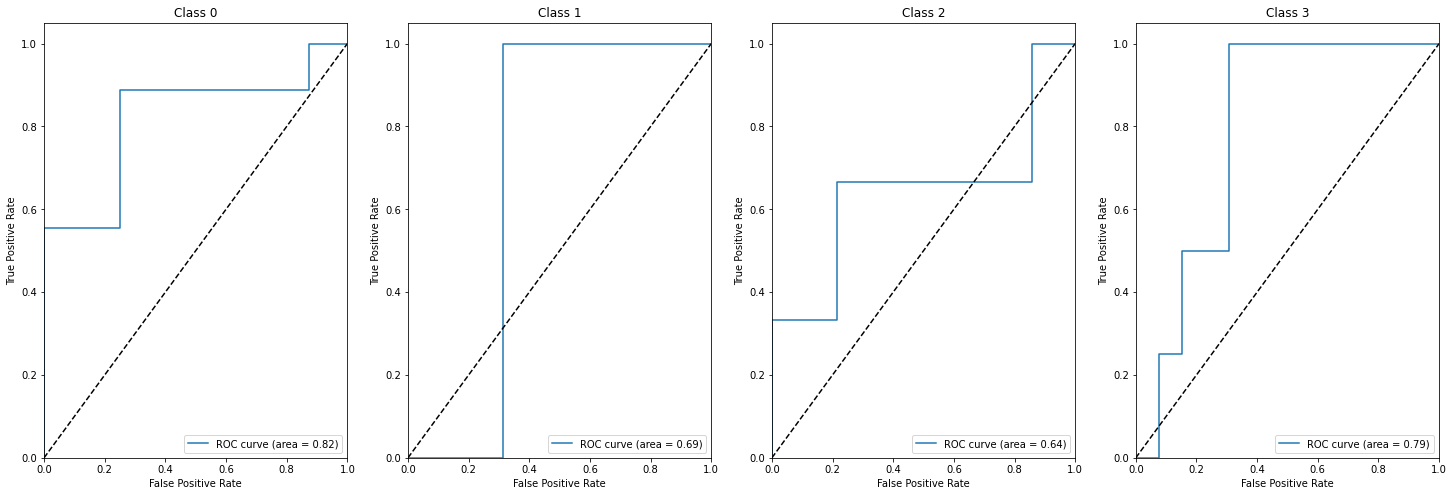

roc_auc_score:  0.7345657814407813


In [18]:
#만든 ANN 모델 다시 검증하고 저장

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold,  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, MaxAbsScaler,  QuantileTransformer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.decomposition import PCA
from sklearn.utils.fixes import loguniform
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.utils import np_utils
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from google.colab import drive
drive.mount('/content/drive')

# fix random seed for reproducibility

seed = 0
np.random.seed(seed)

# load dataset

df = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/MORDRED(3D)/VRK2_MORDRED(3D)_apppendscore_dropsmiles.csv')
df1 = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/MORDRED(3D)/VRK2add_MORDRED(3D)_apppendscore_dropsmiles.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/Others/MORDRED(3D)/Others_MORDRED(3D)_appendscore_dropsmiles.csv')
df3 = pd.concat([df,df1,df2])
data = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/Others/MORDRED(3D)/Drug_MORDRED(3D)_appendscore_dropsmiles.csv')

#데이터 분류

dataset3 = df3.values
X = dataset3[:,:-1]
Y = dataset3[:,-1]

data = data.values
X_others =data[:,:-1]
Y_others =data[:,-1]

Scaler = StandardScaler()

X_scaled = Scaler.fit_transform(X)
X_others_scaled = Scaler.transform(X_others)

#데이터 split

train_input, test_input, train_target, test_target = train_test_split(X_scaled, Y, test_size=0.2, random_state=seed)

#create model

n_feat = X.shape[1]
n_class = len(set(Y))

model = Sequential()
model.add(Dense(877, input_dim=n_feat, activation='relu'))
model.add(Dense(n_class, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_input, train_target, epochs=336, batch_size=28)

#정확도와 confusion matrix 구하기 

pred_train = model.predict(train_input)
pred_train1 = np.argmax(pred_train, axis=1)
pred_test = model.predict(test_input)
pred_test1 = np.argmax(pred_test, axis=1)
pred_total = model.predict(X_scaled)
pred_total1 = np.argmax(pred_total, axis=1)
pred_others = model.predict(X_others_scaled)
pred_others1 = np.argmax(pred_others, axis=1)

accuracy = accuracy_score(train_target, pred_train1)
ex_accuracy = accuracy_score(test_target, pred_test1)
tot_accuracy = accuracy_score(Y, pred_total1)
others_accuracy = accuracy_score(Y_others, pred_others1)

print('train 정확도: {0:.4f}'.format(accuracy))
print('test 정확도: {0:.4f}'.format(ex_accuracy))
print('total 정확도: {0:.4f}'.format(tot_accuracy))
print('others 정확도: {0:.4f}'.format(others_accuracy))

conf = confusion_matrix(train_target, pred_train1, labels=[0,1,2,3])
exconf = confusion_matrix(test_target, pred_test1, labels=[0,1,2,3])
totconf = confusion_matrix(Y, pred_total1, labels=[0,1,2,3])
othersconf = confusion_matrix(Y_others, pred_others1, labels=[0,1,2,3])

print(conf)
print(exconf)
print(totconf)
print(othersconf) 

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(25, 5))
sns.heatmap(conf, annot=True, ax=ax[0])
ax[0].set_title('Internal confusion matrix', pad = 10)
sns.heatmap(exconf, annot=True, ax=ax[1])
ax[1].set_title('External confusion matrix', pad = 10)
sns.heatmap(totconf, annot=True, ax=ax[2])
ax[2].set_title('Total confusion matrix', pad = 10)
sns.heatmap(othersconf, annot=True, ax=ax[3])
ax[3].set_title('Others confusion matrix', pad = 10)

plt.show()

#Classification report 작성

print(classification_report(test_target, pred_test1, labels=[0,1,2,3]))

#roc-auc curve 그리기

#Binarize the output
y_test_bin = label_binarize(test_target, classes=[0,1,2,3])
n_classes = y_test_bin.shape[1] #출력값 4

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure(figsize=(25, 8))
for idx, i in enumerate(range(n_classes)):
    plt.subplot(141+idx)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class %0.0f' % idx)
    plt.legend(loc="lower right")
plt.show()

print("roc_auc_score: ", roc_auc_score(y_test_bin, pred_test))

#모델 저장

model.save('/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/FINAL/VRK2_ANN0430_2.h5')
